In [3]:
import numpy as np
import pywt
import scipy.signal as sig
import matplotlib.pyplot as plt

In [8]:
import numpy as np
X_test = np.load("data_files/X_test.npy")
y_test = np.load("data_files/y_test.npy")
person_train_valid = np.load("data_files/person_train_valid.npy")
X_train_valid = np.load("data_files/X_train_valid.npy")
y_train_valid = np.load("data_files/y_train_valid.npy")
person_test = np.load("data_files/person_test.npy")


### Shape of data

In [9]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [10]:
def plot_rand_sample(X,t,xlabel,ylabel):
    f = plt.figure()
    ax = f.add_subplot(111)
    r = np.random.randint(low=0,high=X.shape[0])
    n = X.shape[1]
    for i in range(n):
        ax.plot(t,X[r,i,:])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

In [11]:
## QUICK VISUALIZATION OF TIME SERIES

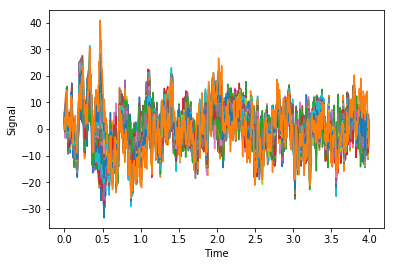

In [12]:
(num_trials,num_electrodes,tsteps) = X_train_valid.shape
fs = 250 # data was sampled at 250 Hz
t = np.arange(0,1000)/fs
plot_rand_sample(X_train_valid,t,'Time','Signal')

In [13]:
## NAIVE FOURIER TRANSFORM

/Users/atonofbuns/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


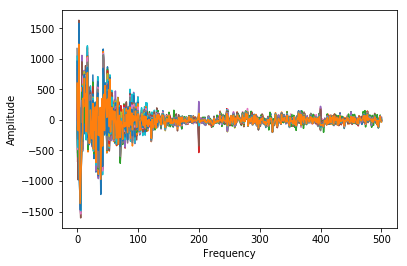

In [14]:
X_train_valid_FFT = np.fft.rfft(X_train_valid)
freq = np.fft.fftfreq(501,d=1/fs)
freq += max(freq)
plot_rand_sample(X_train_valid_FFT,range(501),'Frequency','Amplitude')

In [15]:
# Short-Time Fourier Transform
# Performs a convolution similar to ConvNets but with trig frequencies
# Output will be window//2 + 1 frequencies per time slot, with
# (x_length - window)/stride + 1 time slots.
# Output consists of the magnitude of the corresponding frequency

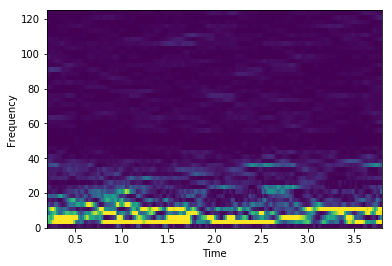

In [17]:
width = 100 #size of "filter" in time
stride = 5
noverlap = width-stride
f,t,X_train_valid_STFT_one = sig.spectrogram(X_train_valid[0,0,:],nperseg=width,noverlap=noverlap,fs=fs,
                             return_onesided=True)
plt.pcolormesh(t,f,np.abs(X_train_valid_STFT_one),vmin=0,vmax=6)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [18]:
X_train_valid_STFT_one.shape

(51, 181)

In [19]:
print(width//2 + 1,(1000-width)/stride +1)

51 181.0


# SHORT-TIME FOURIER TRANSFORM FUNCTION

In [20]:
# Function that computes the short-time fourier transform of the data and returns the spectrogram
#
# Inputs:
# X - input data, last dimension is one which transform will be taken across.
# window - size of sliding window to take transform across
# stride - stride of sliding window across time-series
#
# Returns:
# X_STFT - Output data, same shape as input with last dimension replaced with two new dimensions, F x T.
#          where F = window//2 + 1 is the frequency axis
#          and T = (input_length - window)//stride + 1, similar to the formula for aconvolutional filter.
# t - the corresponding times for the time axis, T
# f - the corresponding frequencies on the frequency axis, F.
#
# Note that a smaller window means only higher frequencies may be found, but give finer time resolution.
# Conversely, a large window gives better frequency resolution, but poor time resolution.

import scipy.signal as sig
import numpy as np

def spectrogram_data(X,window,stride):
    noverlap = window-stride
    print(noverlap)
    if noverlap < 0 :
        print('Stride results in skipped data!')
        return
    f,t,X_STFT = sig.spectrogram(X,nperseg=window,noverlap=noverlap,fs=250, return_onesided=True)
    return (X_STFT, t, f)

Input dimensions: (22, 1000)
95
Expected output dimensions: (22, 51, 181)
Acutal output dimensions: (22, 51, 181)


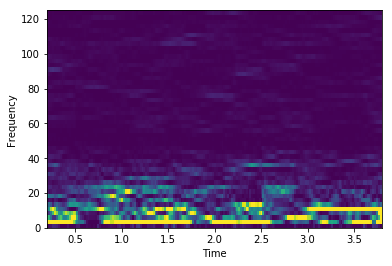

In [21]:
# EXAMPLE USE CASE:
# Convert only one trial's data to a 2D spectrogram input.
# Use a window of size 100, stride of size 5.
# Input is X_train_valid[1,:,:] of dimensions 1 x 22 x 1000
# output x_spect be 1 x 22 x (1000-100)/5 + 1 x 100 // 2.
# We also plot one of the outputs, because why not.

import matplotlib.pyplot as plt

window = 100
stride = 5
print('Input dimensions: {}'.format(X_train_valid[0,:,:].shape))
(X_spect,t,f) = spectrogram_data(X_train_valid[0,:,:],window=window,stride=stride)
print('Expected output dimensions: {}'.format((22,window//2+1,(1000-window)//stride+1)))
print('Acutal output dimensions: {}'.format(X_spect.shape))
plt.pcolormesh(t,f,X_spect[10,:,:],vmin=0,vmax=np.max(X_spect)/10)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [22]:
# DISCRETE WAVELET TRANSFORM OF DATA
# Effectively performs STFT but at varied window sizes with no overlap
# Begins with one full length window
# Proceeds to cut window in half until desired level
# Returns approximation and detail coefficients as critical features
# Don't ask me what they are exactly, they're weird and have to do with some filtering nonsense

In [23]:
wav = pywt.Wavelet('sym9') #selected bc paper I found said it was good
n = X_train_valid.shape[2]
max_level = pywt.dwt_max_level(n,wav)
print('Maximum level of detail recommended: {}'.format(max_level))
data_dim = (n + wav.dec_len - 1)//2
print('Max length of resulting coefficient vectors: {}'.format(data_dim))

test = X_train_valid[0,0,:] #pull one timeseries
coeffs = pywt.wavedec(test,wav,level=max_level,mode='zero')
for c in coeffs:
    print(c.shape)
# Take these as features directly
# Does not provide "new" data per se, but decomposes into new information
coeffs = np.hstack(coeffs)

Maximum level of detail recommended: 5
Max length of resulting coefficient vectors: 508
(47,)
(47,)
(78,)
(139,)
(262,)
(508,)


# DWT FUNCTION

In [24]:
# FUNCTION TO COMPUTE THE DWT OF DATA
# Goes along the last axis of the input data (assuming it is N x C x T)
# Computes the DWT coefficients, and takes these as new features
# Returns new array that is N x C x D,
# where D is the number of DWT coefficients.
# Automatically computes to maximum "useful" depth, uses zero padding
# Takes as input a string describing wavelet
# One that was noted as useful before was 'sym9', or the 9th derivative of the symlet wavelet

import pywt
import numpy as np

def dwt_data(X,wav_name):
    wav = pywt.Wavelet(wav_name)
    n = X.shape[-1] #extract length of timeseries
    max_level = pywt.dwt_max_level(n,wav)
    out1 = np.concatenate(pywt.wavedec(X[0,:,:],wav,level=max_level,mode='zero'),axis=1)
    out = np.empty((X.shape[0],X.shape[1],out1.shape[1]))
    out[0,:,:] = out1
    for i in range(1,X.shape[0]):
        out[i,:,:] = np.concatenate(pywt.wavedec(X[i,:,:],wav,level=max_level,mode='zero'),axis=1)
    return out

In [25]:
# USAGE on TRAINING DATA:
print('Initial dimensions: {}'.format(X_train_valid.shape))
X_DWT = dwt_data(X_train_valid,'sym9')
print('Output dimensions: {}'.format(X_DWT.shape))

Initial dimensions: (2115, 22, 1000)
Output dimensions: (2115, 22, 1081)


In [26]:
# CONTINUOUS WAVELET TRANSFORM
# Effectively does STFT but at various scales (specified by user)

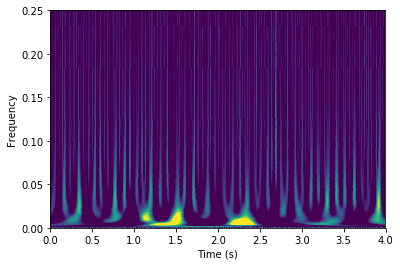

In [43]:
one_sample = X_train_valid[0,0,:]
wav = pywt.ContinuousWavelet('mexh') #mexican hat wavelet bc it sounds funny
scales = np.logspace(start=0,stop=3,num=90)
#scales = np.arange(1,110)
coef, freqs = pywt.cwt(one_sample,scales,wav)
t = np.arange(0,len(one_sample))/fs
plt.pcolormesh(t,freqs,coef,vmin=0,vmax=np.max(coef)/2)
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
plt.show()

In [89]:
# FUNCTION TO COMPUTE CWT OF DATA
# Takes in data, name of wave (I usually use 'mexh' because mexican hat sounds funny)
# Also takes in the top scale parameter.  I use logspace, so scale goes from 1 -> 2^top_scale with num_levels steps.
# Appends to the data a new dimension, of size 'num_levels'
# New dimension corresponds to wavelet content at num_levels different scalings (linear)
# also returns the central frequencies that the scalings correspond to
# input data is N x C X T
# output data is N x C x T x F
# note: CWT is fairly slow to compute

def cwt_data(X,wav_name,num_levels,top_scale=3):
    wav = pywt.ContinuousWavelet(wav_name)
    scales = np.logspace(start=0,stop=top_scale,num=num_levels)
    out = np.empty((X.shape[0],X.shape[1],X.shape[2],num_levels))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            coef, freqs = pywt.cwt(X[i,j,:],scales,wav)
            out[i,j,:] = np.swapaxes((np.squeeze(coef)),0,1)
    return out,freqs

In [ ]:
# EXAMPLE USAGE

test,freqs = cwt_data(X_train_valid[0:5,:,:],'mexh',num_levels=50,top_scale=3)

In [ ]:
t = np.arange(0,X_train_valid.shape[2])/fs
plt.pcolormesh(t,freqs,test[0,0,:,:].T,vmin=0,vmax=np.max(test[0,0,:,:])/5)
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
plt.show()